# Exploratory Analysis on Missing Data

In [1]:
from pathlib import Path
import pandas as pd
import os
wd = Path.cwd().parent
path_to_data = [[wd / "input" / "rosenborg-women_a_2020.xlsx", wd / "input" / "rosenborg-women_a_2021.xlsx"],
                [wd / "input" / "vifwomen_a_2020.xlsx", wd / "input" / "vifwomen_a_2021.xlsx"]]
os.chdir(Path.cwd().parent)
from preprocessing.data_loader import generate_teams
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Load in Data

In [2]:
teams = generate_teams(path_to_data, ["VI", "Rosenborg"])
players = teams["Rosenborg"].players

In [3]:
nan_signal = []
for player in players.values():
    for attr in player.__dataclass_fields__:
        attribute = getattr(player, attr)
        if isinstance(attribute, pd.Series):
            nan_signal.append(attribute.isna().sum()/ len(attribute))
    
    

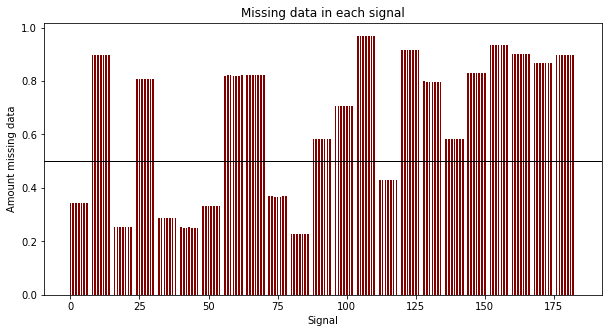

In [4]:
fig = plt.figure(figsize = (10, 5))

plt.bar(range(0,len(nan_signal)), nan_signal, color ='maroon',
        width = 0.6)
plt.axhline(y=0.5,linewidth=1, color='k')
plt.xlabel("Signal")
plt.ylabel("Amount missing data")
plt.title("Missing data in each signal")
plt.show()

In [5]:
nr_missing_data = []
for player in players.values():
    readiness = player.readiness.isna().sum()/len(player.readiness)
    soreness = player.soreness.isna().sum()/len(player.soreness)
    stress = player.stress.isna().sum()/len(player.stress)
    fatique = player.fatigue.isna().sum()/len(player.fatigue)
    mood = player.mood.isna().sum()/len(player.mood)
    sleep_dur = player.sleep_duration.isna().sum()/len(player.sleep_duration)
    sleep_qual = player.sleep_quality.isna().sum()/len(player.sleep_quality)
    nr_missing_data.append(np.mean([readiness, soreness, stress, fatique, mood, sleep_dur, sleep_qual]))

#missing_data_per_player = [value/total_data_per_player for value in nr_missing_data]
missing_data_per_player = nr_missing_data

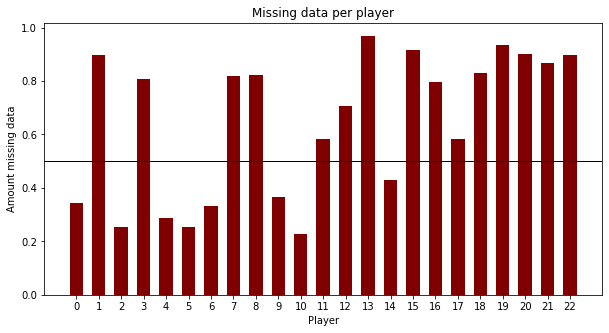

In [6]:
fig = plt.figure(figsize = (10, 5))

plt.bar(players.keys(), missing_data_per_player, color ='maroon',
        width = 0.6)
plt.axhline(y=0.5,linewidth=1, color='k')
plt.xlabel("Player")
plt.ylabel("Amount missing data")
plt.title("Missing data per player")
plt.show()

## Singular Spectrum Analysis

<AxesSubplot:xlabel='Readiness Data'>

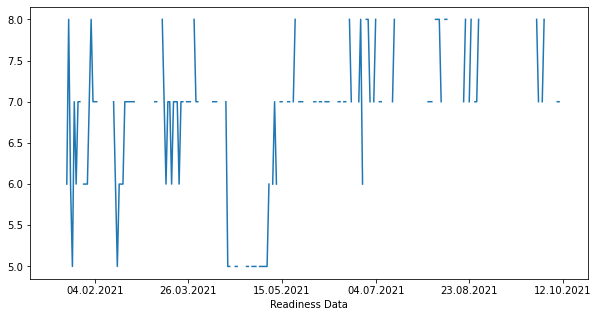

In [7]:
fig = plt.figure(figsize = (10, 5))
players["16"].readiness.plot()

In [19]:
L = 31 # The window length.
K = len(players["16"].readiness) - L + 1 # The number of columns in the trajectory matrix.
# Create the trajectory matrix by pulling the relevant subseries of F, and stacking them as columns.
X = np.column_stack([players["16"].readiness.to_numpy()[i:i+L] for i in range(0,K)])

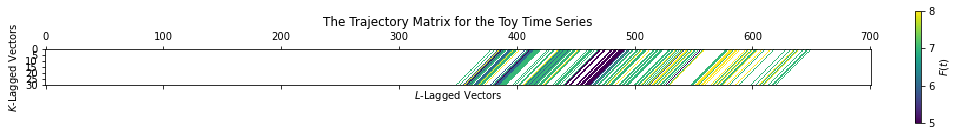

In [20]:
ax = plt.matshow(X)
plt.xlabel("$L$-Lagged Vectors")
plt.ylabel("$K$-Lagged Vectors")
plt.colorbar(ax.colorbar, fraction=0.025)
ax.colorbar.set_label("$F(t)$")
plt.title("The Trajectory Matrix for the Toy Time Series");


In [21]:
from fancyimpute import SoftImpute, KNN
X_filled_knn = KNN().fit_transform(X)
X_filled_softimpute = SoftImpute().fit_transform(X)


Imputing row 1/31 with 553 missing, elapsed time: 0.009
[KNN] Warning: 12369/21731 still missing after imputation, replacing with 0
[SoftImpute] Max Singular Value of X_init = 343.921950
[SoftImpute] Iter 1: observed MAE=0.427373 rank=31
[SoftImpute] Iter 2: observed MAE=0.426793 rank=31
[SoftImpute] Iter 3: observed MAE=0.425972 rank=31
[SoftImpute] Iter 4: observed MAE=0.424889 rank=31
[SoftImpute] Iter 5: observed MAE=0.423534 rank=31
[SoftImpute] Iter 6: observed MAE=0.421932 rank=31
[SoftImpute] Iter 7: observed MAE=0.420058 rank=31
[SoftImpute] Iter 8: observed MAE=0.417852 rank=31
[SoftImpute] Iter 9: observed MAE=0.415605 rank=31
[SoftImpute] Iter 10: observed MAE=0.413721 rank=31
[SoftImpute] Iter 11: observed MAE=0.412382 rank=31
[SoftImpute] Iter 12: observed MAE=0.411873 rank=31
[SoftImpute] Iter 13: observed MAE=0.412102 rank=31
[SoftImpute] Iter 14: observed MAE=0.410441 rank=29
[SoftImpute] Iter 15: observed MAE=0.408468 rank=29
[SoftImpute] Iter 16: observed MAE=0.40821

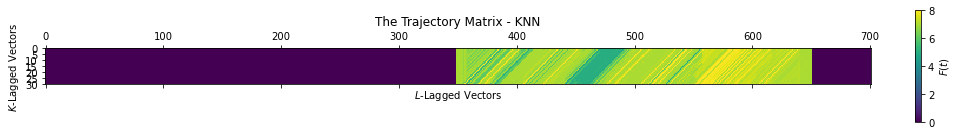

In [22]:
ax = plt.matshow(X_filled_knn)
plt.xlabel("$L$-Lagged Vectors")
plt.ylabel("$K$-Lagged Vectors")
plt.colorbar(ax.colorbar, fraction=0.025)
ax.colorbar.set_label("$F(t)$")
plt.title("The Trajectory Matrix - KNN");

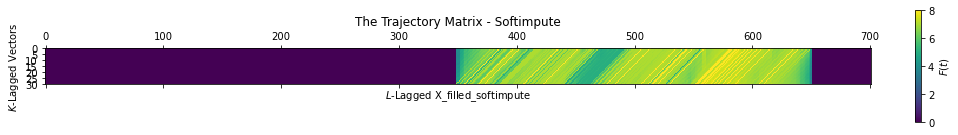

In [23]:
ax = plt.matshow(X_filled_softimpute)
plt.xlabel("$L$-Lagged X_filled_softimpute")
plt.ylabel("$K$-Lagged Vectors")
plt.colorbar(ax.colorbar, fraction=0.025)
ax.colorbar.set_label("$F(t)$")
plt.title("The Trajectory Matrix - Softimpute");

In [24]:
def X_to_TS(X_i):
    """Averages the anti-diagonals of the given elementary matrix, X_i, and returns a time series."""
    X_rev = X_i[::-1]
    return np.array([X_rev.diagonal(i).mean() for i in range(-X_i.shape[0]+1, X_i.shape[1])])


In [25]:
reconstructed_ts_softimpute = X_to_TS(X_filled_softimpute)
reconstructed_ts_knn = X_to_TS(X_filled_knn)


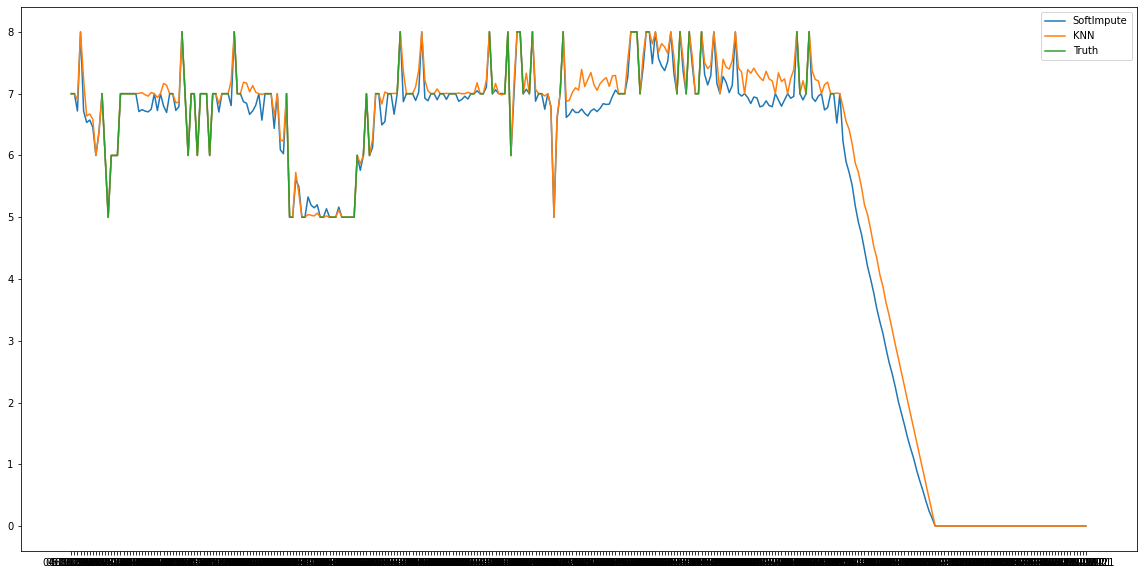

In [27]:
fig = plt.figure(figsize = (20, 10))
plt.plot(reconstructed_ts_softimpute[400:], label='SoftImpute')
plt.plot(reconstructed_ts_knn[400:], label='KNN')

plt.plot(players["16"].readiness[400:], label= "Truth")
plt.legend()

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_pacf(reconstructed_ts_month[400:], lags=60)

In [ ]:
plot_acf(reconstructed_ts_month[400:], lags=60)

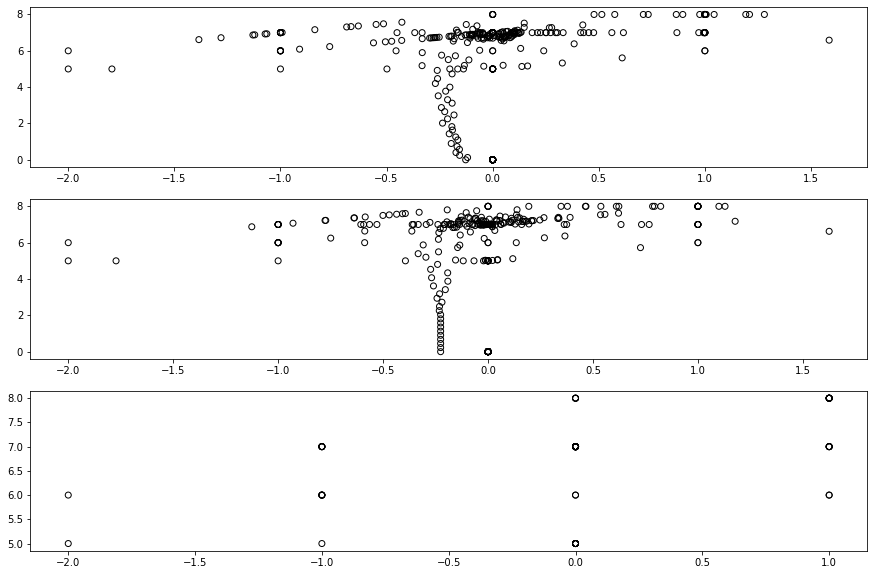

In [28]:
fig, (ax_1, ax_2, ax_3) = plt.subplots(nrows=3, ncols=1, figsize=(15,10))
ax_1.scatter(reconstructed_ts_softimpute[400:],pd.Series(reconstructed_ts_softimpute[400:]).diff() label='SoftImpute', facecolors='none', edgecolors='black')
ax_2.scatter(reconstructed_ts_knn[400:],pd.Series(reconstructed_ts_knn[400:]).diff() label='KNN', facecolors='none', edgecolors='black')
ax_3.scatter(players["16"].readiness[400:]players["16"].readiness[400:].diff(),, label='KNN', facecolors='none', edgecolors='black')


(0.0, 10.0)

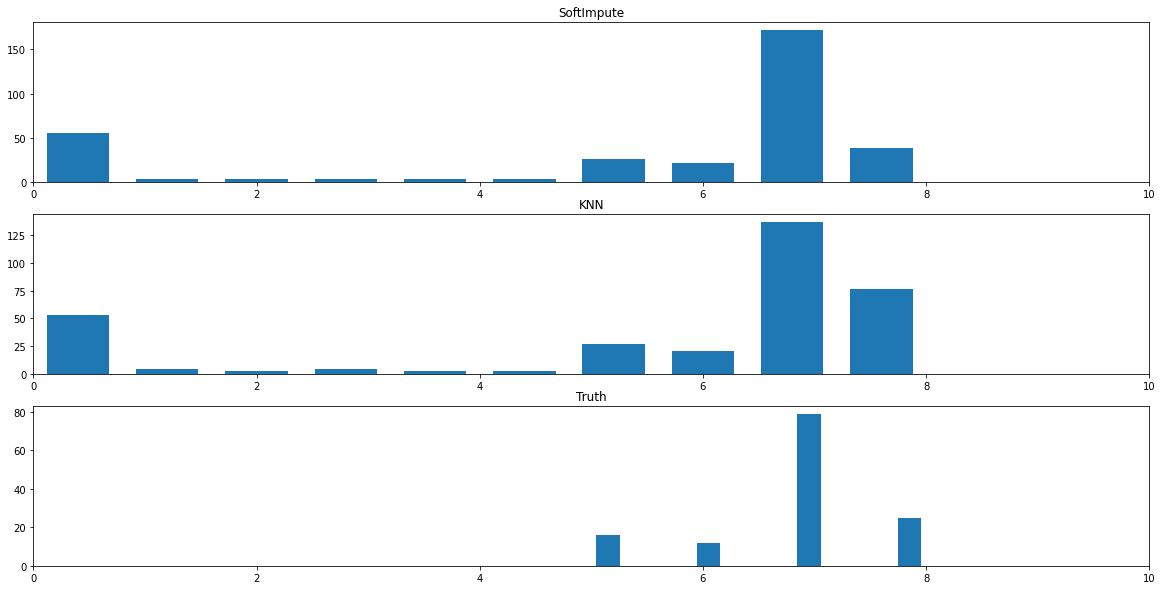

In [35]:
fig, (ax_1, ax_2, ax_3) = plt.subplots(nrows=3, ncols=1, figsize = (20, 10))
ax_1.hist(reconstructed_ts_softimpute[400:], rwidth=0.7, label= "SoftImpute")
ax_1.set_title("SoftImpute")
ax_1.set_xlim(0,10)
ax_2.hist(reconstructed_ts_knn[400:], rwidth=0.7, label= "KNN")
ax_2.set_title("KNN")
ax_2.set_xlim(0,10)
ax_3.hist(players["16"].readiness[400:],rwidth=0.7, label= "Truth")
ax_3.set_title("Truth")
ax_3.set_xlim(0,10)